In [6]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.rc('font', family='NanumBarunGothic') 


In [2]:

#데이터 불러오기
df=pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv').drop(columns='Unnamed: 0')

#결측치 확인 - 출시연도, 장르, 제작사 컬럼 결측치 처리 필요
df.isna().sum()

#출고량 데이터 확인 - 단위정리 필요함. K,M이 혼용됨
df['EU_Sales'].unique()
df['JP_Sales'].unique()
df['NA_Sales'].unique()
df['Other_Sales'].unique()

#범주형 데이터의 대략적인 고유값과 빈도 확인
df['Platform'].unique()
df['Platform'].value_counts()
df['Publisher'].unique() 
df['Publisher'].value_counts()
df['Genre'].unique()
df['Genre'].value_counts()

#연도 데이터 형식 확인 - yyyy,yy,y 형식이 혼용되어 있어 통일 필요
df['Year'].unique()
df['Year'].value_counts()


2009.0    1421
2008.0    1418
2010.0    1252
2007.0    1199
2011.0    1129
          ... 
13.0         2
12.0         2
86.0         1
2020.0       1
94.0         1
Name: Year, Length: 62, dtype: int64

In [3]:
#결측치 처리
#장르는 기타 분류가 있어 기타로 처리
df['Genre']=df['Genre'].fillna('Misc')
#제작사는 '-'로 처리
df['Publisher']=df['Publisher'].fillna('-')

#연도는 271개의 결측치를 0이나 평균연도로 처리하면 통계에 영향이 있을 것 같아서 일단 놔두고 형식 통일 진행하였음
#소수점 없앤 후 string으로 변환
df['Year']=df['Year'].astype('Int64').astype('str')
#두자리로 연도가 표기된 경우 앞에 0이 유실되어있음 (06->6, 07->7)
df['Year'].unique()
#데이터가 두자리가 안되는경우 앞에 0을 채워줌
df['Year']=df['Year'].str.zfill(2)
#datetime형식으로 변환하기. 1차로 4자리 형태 변환하고 2차로 2자리 형태 변환 //왜 이게되지?
df['Year']=pd.to_datetime(df['Year'], format=('%Y'),errors="coerce").fillna(pd.to_datetime(df['Year'], format="%y", errors="coerce"))
#소수점 없애려고 정수로 변환
df['Year']=df['Year'].dt.year.astype('Int64')

In [4]:
#출고량 데이터를 위한 단위 변환 함수
#기본 데이터가 M단위로 되어있어 M으로 통일함
def toFloat(str):
  if 'K' in str:
    str=str.replace('K','')
    return float(str)/1000   #K인경우 M으로 맞춰주기위해 1000으로 나눠서 리턴
  elif 'M' in str:
    str=str.replace('M','')
    return float(str)
  else:
   return float(str)

#출고량 데이터에 함수 적용해서 저장
df['JP_Sales']=df['JP_Sales'].apply(toFloat)
df['NA_Sales']=df['NA_Sales'].apply(toFloat)
df['Other_Sales']=df['Other_Sales'].apply(toFloat)
df['EU_Sales']=df['EU_Sales'].apply(toFloat)

#이러한 방식도 있다길래 해봤는데 엄청 느림.. 왤까?
# df["JP_Sales"].replace({"K":"*1e-3", "M":""}, regex=True).map(pd.eval).astype(float)

#새 피쳐 생성
df['Total_Sales'] = df['NA_Sales'] + df['JP_Sales'] + df['EU_Sales'] +df['Other_Sales']

In [5]:
#시각화 준비
df2=df.copy()
#컬럼명 한글화
df2.rename(columns = {"Name":"게임명", "Platform": "플랫폼", "Year": "출시연도", "Genre": "장르", 
                      "Publisher":"제작사", "NA_Sales": "북미출고량", "EU_Sales": "유럽출고량", 
                      "JP_Sales": "일본출고량", "Other_Sales": "기타출고량", "Total_Sales": "총출고량"}, inplace=True)

#5년 단위 연도 피쳐 생성
df2['출시연도(5년단위)'] = df2['출시연도'] - df2['출시연도'] % 5
df2['출시연도(5년단위)'] = df2['출시연도(5년단위)'].astype('Int64')

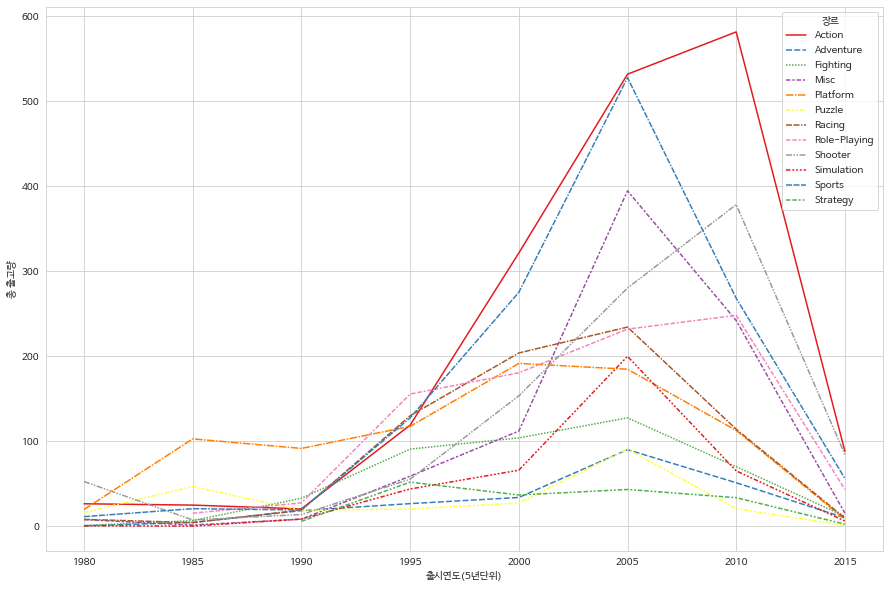

In [6]:
#총출고량을 연도별로 그룹핑하고, 연도를 행으로 장르를 열으로 한 피봇 데이터 프레임 만들기
df3=df2['총출고량'].groupby([df2["출시연도(5년단위)"], df2["장르"]]).sum().unstack("장르")
#2020 이후 범위에 속한 데이터는 단 하나로, 시각화 하기에 너무 적은 데이터라 삭제하였음
df3=df3.drop(df3.tail(1).index)
#라인플롯 그리기
plt.figure(figsize=(15,10))
sns.set_style('whitegrid')
plt.rc('font', family='NanumBarunGothic') #set_style을 하면 폰트설정이 초기화가 되는 듯함.. 여기서 이설정을 다시 꼭넣어줘야 에러가 안나서 넣어주기
sns.lineplot(data=df3,palette='Set1')
plt.ylabel('총 출고량')
plt.show()
#총 출고량은 데이터의 양을 따라가는 양상을 보이는 것 같아 평균으로 다시 시각화하기로함

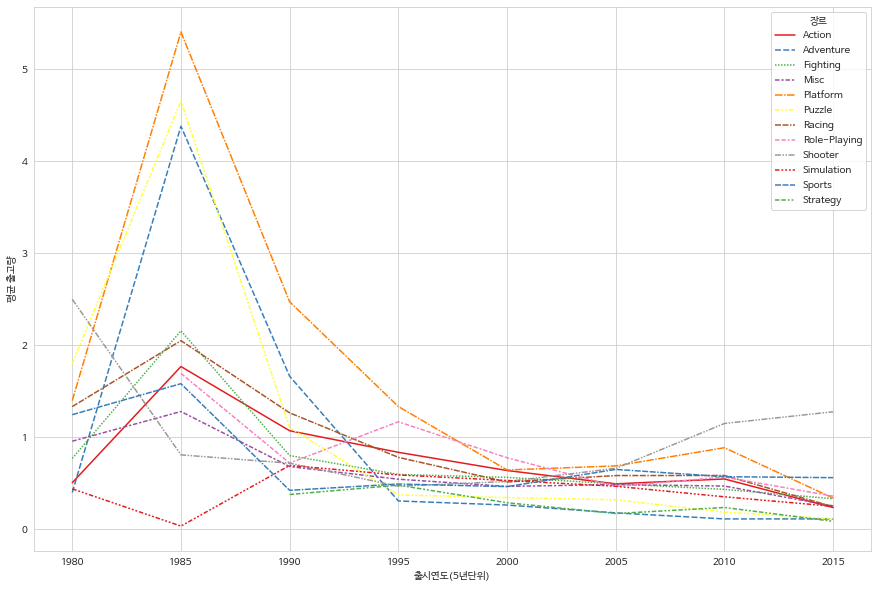

In [8]:
plt.figure(figsize=(15,10))
#위의 그래프에서 총 출고량->평균 출고량으로 변경한 그래프 그리기
df4=df2["총출고량"].groupby([df2["출시연도(5년단위)"], df2["장르"]]).mean().unstack("장르")
#2020 이후 범위에 속한 데이터는 단 하나로, 시각화 하기에 너무 적은 데이터라 삭제하였음
df4=df4.drop(df4.tail(1).index)
sns.set_style('whitegrid')
plt.rc('font', family='NanumBarunGothic')
sns.lineplot(data=df4,palette='Set1') 
plt.ylabel('평균 출고량')
plt.show()
#1990년대까지의 데이터가 적어서 장르별 편차가 크게나옴

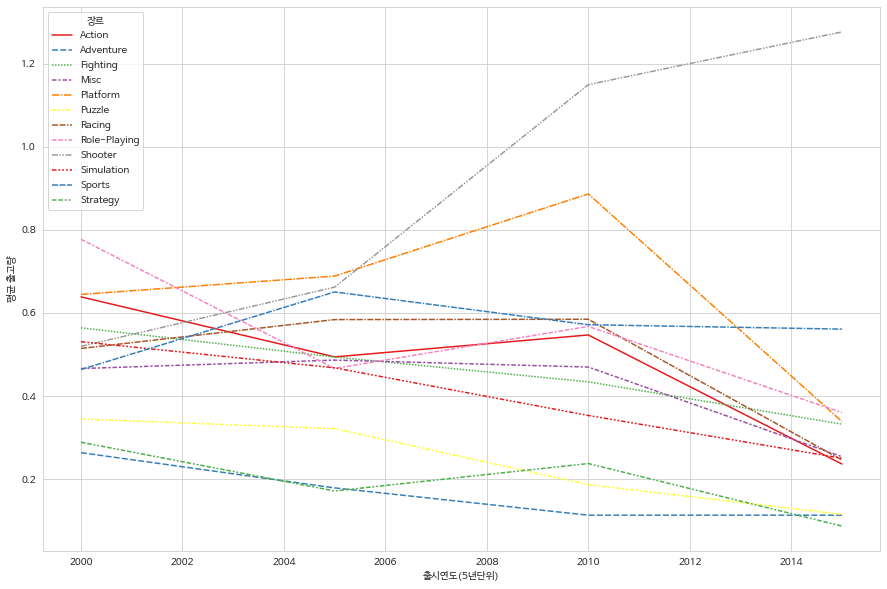

In [9]:
#2000년도 이상 데이터를 자세히 확인하기 위해 다시 시각화
plt.figure(figsize=(15,10))
df4=df4.drop(df4.head(4).index)
sns.set_style('whitegrid')
plt.rc('font', family='NanumBarunGothic')
sns.lineplot(data=df4, palette='Set1') 
plt.ylabel('평균 출고량')
plt.show()
##총판매량으로 보면 액션이 앞서고, 평균을 내보면 슈팅장르의 출고량이 높다.

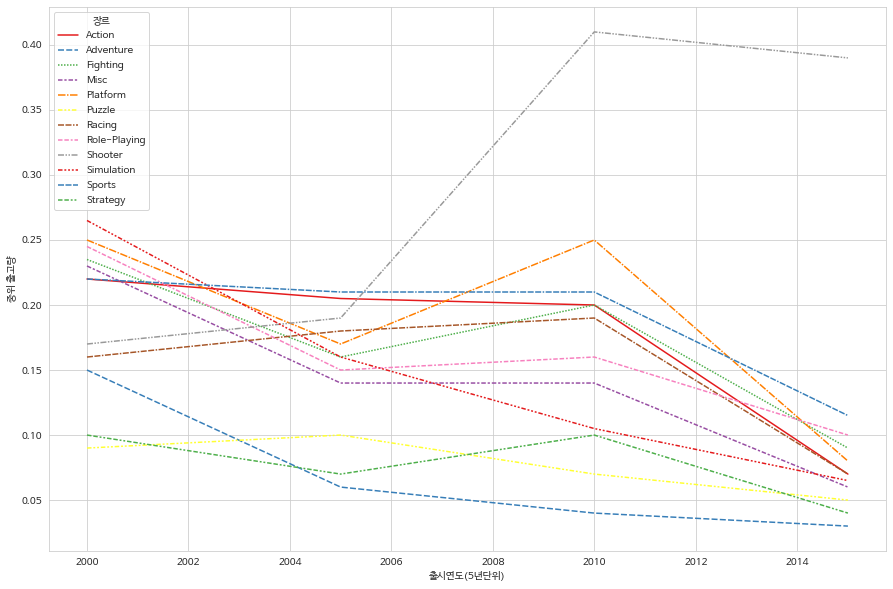

In [10]:
plt.figure(figsize=(15,10))
#평균은 극단값에 영향을 크게 받을 수도 있으니 중앙값으로도 비교해보기
df5=df2["총출고량"].groupby([df2["출시연도(5년단위)"], df2["장르"]]).median().unstack("장르")
df5=df5.drop(df5.head(4).index)
df5=df5.drop(df5.tail(1).index)
sns.set_style('whitegrid')
plt.rc('font', family='NanumBarunGothic')
sns.lineplot(data=df5, palette='Set1') 
plt.ylabel('중위 출고량')
plt.show()

#중앙값도 평균과 비슷한 양상으로 나타나며 슈터장르의 출고량이 높다.

In [11]:
from scipy import stats
#장르에 따라 지역별 출고량이 다르게 나올지 확인해보기
#카이제곱 검정으로 장르-지역 간에 연관성을 보기로함

#귀무가설-장르에 따라 지역별 출고량이 차이가 없다
#대립가설-장르에 따라 지역별 출고량이 차이가 있다

#장르-지역 피봇테이블 만들기
chi_df=df2.groupby(df2['장르']).sum()
#지역별출고량 컬럼만 자르기
chi_df=chi_df.iloc[:,1:5]

#가설검정시행
stats.chi2_contingency(chi_df)[1]
#P_value가 0.5보다 작으므로 대립가설이 채택된다.

#카이검정제곱 결과에 따르면 지역별 출고량은 장르에 따른 차이를 보일 것이다. 
#어떤연관성을 보이는지 시각화해보기로

1.1562515653971526e-124

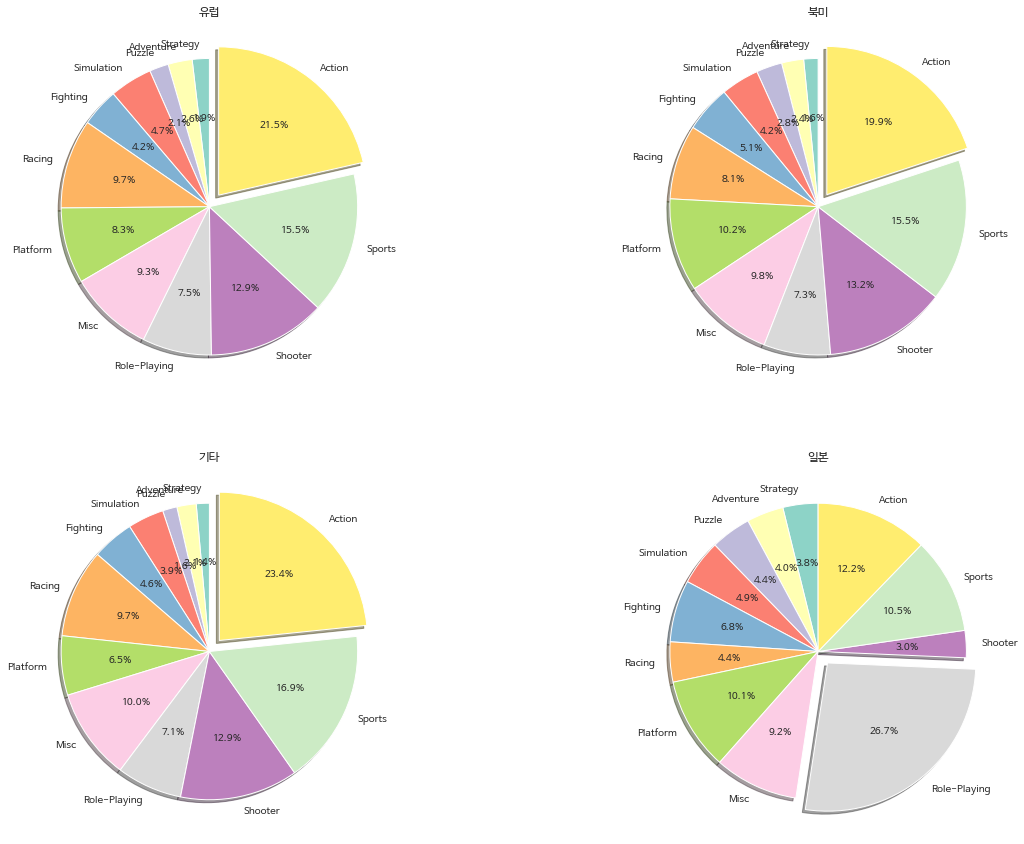

In [12]:
#지역에 따라 선호하는 게임 장르 시각화하기
#유럽,북미,기타,일본 각 지역별로 총 출고량이 다르기 때문에 해당 지역의 총 출고량 중 각 장르가 차지하는 비율로써 비교할 수 있도록 파이플롯으로 시각화하였음
df6=df2.groupby('장르').sum().sort_values(by='총출고량')
plt.figure(figsize=(20,15))
sns.set_palette("Set3")
plt.rc('font', family='NanumBarunGothic')
plt.subplot(2,2,1)
plt.title('유럽')
plt.pie(x='유럽출고량',data=df6, labels=df6.index, autopct='%1.1f%%',shadow = True,startangle = 90,explode = (0,0,0,0,0,0,0,0,0,0,0,0.1))
plt.subplot(2,2,2)
plt.title('북미')
plt.pie(x='북미출고량',data=df6, labels=df6.index, autopct='%1.1f%%',shadow = True,startangle = 90,explode = (0,0,0,0,0,0,0,0,0,0,0,0.1))
plt.subplot(2,2,3)
plt.title('기타')
plt.pie(x='기타출고량',data=df6, labels=df6.index, autopct='%1.1f%%',shadow = True,startangle = 90,explode = (0,0,0,0,0,0,0,0,0,0,0,0.1))
plt.subplot(2,2,4)
plt.title('일본')
plt.pie(x='일본출고량',data=df6, labels=df6.index, autopct='%1.1f%%',shadow = True,startangle = 90,explode = (0,0,0,0,0,0,0,0,0.1,0,0,0))
plt.show()
#유럽,북미,기타지역은 장르 선호 순위가 1위액션, 2위스포츠, 3위슈터장르로 비슷하지만 일본만 1위가 롤플레잉 게임으로 매우 다르다.
#특히 슈터장르는 일본의 총 출고량중 단 3%만 차지하는 비주류 장르인 것으로 나타남.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


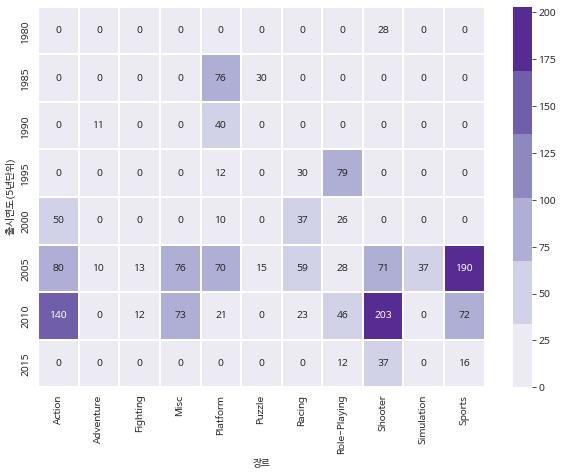

,게임명,출시연도,장르,북미출고량,유럽출고량,일본출고량,기타출고량,총출고량,출시연도(5년단위)
0,Wii Sports,2006,Sports,41.49,29.02,3.77,8.46,82.74,2005
4,Wii Sports Resort,2009,Sports,15.75,11.01,3.28,2.96,33.00,2005
20,Wii Fit,2007,Sports,8.94,8.03,3.60,2.15,22.72,2005
21,Wii Fit Plus,2009,Sports,9.09,8.59,2.53,1.79,22.00,2005
77,FIFA Soccer 10,2009,Sports,1.94,6.23,0.07,2.49,10.73,2005
95,FIFA Soccer 08,2007,Sports,1.96,3.97,0.04,3.53,9.50,2005
99,Madden NFL 07,2006,Sports,7.89,0.41,0.03,0.89,9.22,2005


In [16]:
#출고량이 높은 게임들에 어떤 특징이 나타나는지 알아보기 위해 총 출고량이 높은 순으로 100개의 데이터를 따로 분석하기로

#출고량이 높은 게임들로 sort하기 위해서 새로운 데이터프레임 만듦
#게임명, 출시연도, 장르가 같으면 같은 게임일것이라고 판단하고 묶어주었음. 
#(한 게임인데 여러 플랫폼으로 출시된 경우 데이터가 나눠져있어서 게임별로 데이터를 통합하기 위해)
top100=df2.groupby(['게임명','출시연도','장르']).sum().sort_values(by='총출고량', ascending=False).head(100)
top100=top100.reset_index()
#5년 단위 연도 새로 저장
top100=top100.iloc[:,:-1]
top100['출시연도(5년단위)'] = top100['출시연도'] - top100['출시연도'] % 5
top100['출시연도(5년단위)'] = top100['출시연도(5년단위)'].astype('Int64')
#데이터 시각화를 위한 출시연도x장르 데이터 준비
df7=top100['총출고량'].groupby([top100['출시연도(5년단위)'],top100['장르']]).sum().unstack('장르')
df7=df7.fillna(0)
plt.figure(figsize=(10,7))
sns.heatmap(df7, annot=True, fmt='.0f' ,cmap=sns.color_palette('Purples'), linewidths = 1)
plt.show()

#진하게 나타나는 부분의 데이터를 출력해보면 다음과 같음
top100[(top100['장르']=='Action')&(top100['출시연도(5년단위)']==2010)] #GTA
top100[(top100['장르']=='Shooter')&(top100['출시연도(5년단위)']==2010)] #콜오브듀티
top100[(top100['장르']=='Sports')&(top100['출시연도(5년단위)']==2005)] #wii

#출고량이 높은 게임들의 특성은 인기시리즈물의 출시 시기와 장르에 따라 크게 좌우됨

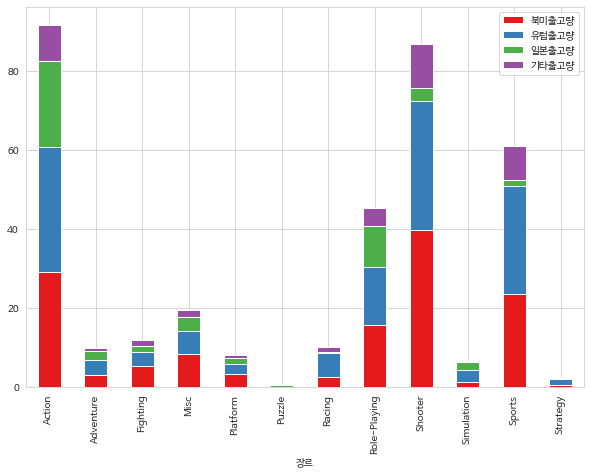

In [73]:
#그렇다면 가장 최근에 출시된 게임들을 위주로 분석해보자.
#출시연도 최신 순으로 1000개 데이터를 새 데이터프레임으로 저장
new1000=df2.sort_values(by='출시연도', ascending=False).head(1000)

#장르별로 출고량을 시각화하기 위해 그룹핑하기
df8=new1000.groupby('장르').sum()
df8=df8.iloc[:,1:5]

sns.set_palette("Set1")
sns.set_style('whitegrid')
plt.rc('font', family='NanumBarunGothic')
df8.plot(kind='bar', stacked=True, figsize=(10,7))

plt.show()

# 장르별 총출고량은 액션-스포츠-슈터 순이었는데,
# 최근 데이터 위주로 확인하니 액션-슈터-스포츠 순으로, 슈터가 2위로 올라선 것으로 확인됨

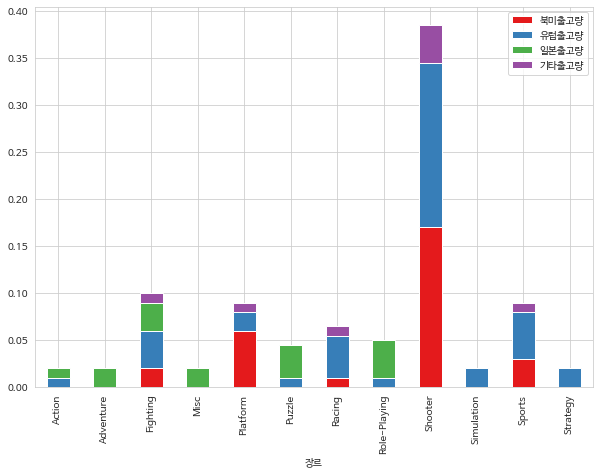

In [76]:
#중위값으로도 시각화해보기
df9=new1000.groupby('장르').median()
df9=df9.iloc[:,1:5]

sns.set_palette("Set1")
sns.set_style('whitegrid')
plt.rc('font', family='NanumBarunGothic')
df9.plot(kind='bar', stacked=True,figsize=(10,7))
plt.show()

#슈터게임의 출고량 중위값이 유독 높은 것을 알 수 있음
#대작이 많아서 일수도 있음 (여기는 도메인 지식이 필요한 영역이 아닐까..?)

#총 결론
#일본시장을 주력으로 하는 경우만 아니라면 슈터장르 게임을 출시하는게 경쟁력이 있을 것으로 보인다.
#추후 게임 장르별 제작단가나 개발환경을 따져서 결정하면 좋을 것 같다.
